In [ ]:
"""
compiled_lora.ipynb

This script benchmarks the effect of PyTorch's `torch.compile` feature on ChemBERTa models fine-tuned with LoRA adapters.

Key Features:
- Fine-tunes ChemBERTa with LoRA on the ClinTox dataset.
- Runs three training regimes:
    1. Baseline (no compilation)
    2. torch.compile (default mode)
    3. torch.compile with 'reduce-overhead' mode
- Measures and compares training time per epoch, total training time, throughput, test accuracy, and GPU memory usage.
- Plots and logs all metrics for easy comparison.

This script is useful for demonstrating the real-world speedup and efficiency gains possible with PyTorch's graph-based optimizations, especially when combined with parameter-efficient fine-tuning.
"""

In [13]:
%%capture
!pip install deepchem transformers peft

In [14]:
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("deepchem").setLevel(logging.ERROR)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import deepchem as dc
from peft import get_peft_model, LoraConfig, TaskType
import time
from sklearn.metrics import accuracy_score
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(10)

In [16]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [17]:
# Define paths and parameters
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 3e-4

# LoRA Configuration
LORA_R = 8  # Rank of LoRA
LORA_ALPHA = 16
LORA_DROPOUT = 0.1

In [18]:
class ClinToxDataset(Dataset):
    def __init__(self, data_path, tokenizer, split='train', max_length=128):
        """
        Custom PyTorch Dataset for the ClinTox dataset.
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split

        # Load ClinTox dataset from DeepChem
        tasks, datasets, transformers = dc.molnet.load_clintox()
        train_dataset, valid_dataset, test_dataset = datasets

        # Convert to SMILES and labels
        self.smiles_train, self.labels_train = self.remove_invalid_smiles(train_dataset.ids, train_dataset.y)
        self.smiles_valid, self.labels_valid = self.remove_invalid_smiles(valid_dataset.ids, valid_dataset.y)
        self.smiles_test, self.labels_test = self.remove_invalid_smiles(test_dataset.ids, test_dataset.y)

        # Set active split
        if split == 'train':
            self.smiles = self.smiles_train
            self.labels = self.labels_train
        elif split == 'valid':
            self.smiles = self.smiles_valid
            self.labels = self.labels_valid
        elif split == 'test':
            self.smiles = self.smiles_test
            self.labels = self.labels_test
        else:
            raise ValueError("Invalid split. Use 'train', 'valid', or 'test'.")

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            smiles,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

    def remove_invalid_smiles(self, smiles, labels):
        """
        Filters out invalid SMILES strings using RDKit validation.
        """
        valid_indices = []
        for i, smile in enumerate(smiles):
            try:
                mol = Chem.MolFromSmiles(smile)
                if mol is not None:
                    valid_indices.append(i)
            except:
                pass

        return smiles[valid_indices], labels[valid_indices]

In [19]:
def setup_lora_model(model_name):
    """
    Set up a model with LoRA configuration
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,  # Binary classification for ClinTox
        return_dict=True
    )

    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        target_modules=["query", "value"]  # Target attention modules
    )

    model = get_peft_model(model, peft_config)
    return model

In [20]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on the validation or test set.
    """
    model.eval()
    total_loss = 0
    all_labels = []
    all_preds = []
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Binary predictions for accuracy
    bin_preds = (all_preds > 0.5).astype(int)
    accuracy = accuracy_score(all_labels, bin_preds)

    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [21]:
def train_and_profile(model, tokenizer, optimization_name):
    """
    Train and evaluate a model with comprehensive logging to Weights & Biases
    """

    wandb.init(
        project="chemberta",
        entity="hpml-proj-deepchem",
        name=f"{optimization_name}_torch.compile_train",
        config={
            "model_name": MODEL_NAME,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "learning_rate": LEARNING_RATE,
            "lora_r": LORA_R,
            "lora_alpha": LORA_ALPHA,
            "lora_dropout": LORA_DROPOUT,
            "optimization": optimization_name
        }
    )

    # Create datasets for each split
    train_dataset = ClinToxDataset("clintox", tokenizer, split="train", max_length=MAX_LENGTH)
    val_dataset = ClinToxDataset("clintox", tokenizer, split="valid", max_length=MAX_LENGTH)
    test_dataset = ClinToxDataset("clintox", tokenizer, split="test", max_length=MAX_LENGTH)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses, val_accuracies, epoch_times = [], [], [], []

    print(f"\n--- {optimization_name} ---")

    torch.cuda.reset_peak_memory_stats(device)

    start_time = time.time()
    total_samples = 0

    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_samples += input_ids.size(0)
            total_train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        epoch_time = time.time() - epoch_start_time
        avg_train_loss = total_train_loss / len(train_dataloader)
        val_loss, val_acc = evaluate_model(model, val_dataloader, device)

        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} | Training Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    end_time = time.time()
    total_train_time = end_time - start_time
    throughput = total_samples / total_train_time
    peak_memory_MB = torch.cuda.max_memory_allocated(device) / (1024 ** 2) if torch.cuda.is_available() else 0

    test_loss, test_acc = evaluate_model(model, test_dataloader, device)

    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_acc,
        "training_time": total_train_time,
        "throughput": throughput,
        "peak_gpu_memory": peak_memory_MB
    })

    fig, ax = plt.subplots(figsize=(10, 6))
    epochs = list(range(1, EPOCHS + 1))
    ax.plot(epochs, train_losses, label='Training Loss')
    ax.plot(epochs, val_losses, label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training/Validation Loss - {optimization_name}')
    ax.legend()
    ax.grid(True)

    wandb.log({f"{optimization_name}_loss_curves_torch.compile": wandb.Image(fig)})

    # Create and log accuracy curve
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Validation Accuracy - {optimization_name}')
    ax.legend()
    ax.grid(True)

    wandb.log({f"{optimization_name}_accuracy_curve_torch.compiles": wandb.Image(fig)})

    # Create and log accuracy curve
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(epochs, epoch_times, label='Epoch Train Time', color='green')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Time (s)')
    ax.set_title(f'Epoch Training Times - {optimization_name}')
    ax.legend()
    ax.grid(True)

    wandb.log({f"{optimization_name}_epoch_times_torch.compile": wandb.Image(fig)})
    wandb.finish()


    print(f"\n--- {optimization_name} ---")
    print(f"Total Training Time: {total_train_time:.2f} seconds")
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    print(f"Throughput: {throughput:.2f} samples/sec")
    print(f"Peak GPU Memory Usage: {peak_memory_MB:.2f} MB")


    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "epoch_times": epoch_times,
        "training_time": total_train_time,
        "test_accuracy": test_acc,
        "throughput": throughput,
        "peak_memory_usage": peak_memory_MB}

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Baseline ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.39it/s]


Epoch 1 | Training Time: 4.11s | Train Loss: 0.1686 | Val Loss: 0.1131 | Val Accuracy: 0.9392


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.37it/s]


Epoch 2 | Training Time: 4.12s | Train Loss: 0.0764 | Val Loss: 0.0849 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.11it/s]


Epoch 3 | Training Time: 4.13s | Train Loss: 0.0595 | Val Loss: 0.0693 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.15it/s]


Epoch 4 | Training Time: 4.13s | Train Loss: 0.0482 | Val Loss: 0.1297 | Val Accuracy: 0.9392


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.05it/s]


Epoch 5 | Training Time: 4.13s | Train Loss: 0.0388 | Val Loss: 0.0871 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.22it/s]


Epoch 6 | Training Time: 4.09s | Train Loss: 0.0319 | Val Loss: 0.0781 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.17it/s]


Epoch 7 | Training Time: 4.08s | Train Loss: 0.0260 | Val Loss: 0.0729 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.14it/s]


Epoch 8 | Training Time: 4.08s | Train Loss: 0.0322 | Val Loss: 0.0706 | Val Accuracy: 0.9865


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.08it/s]


Epoch 9 | Training Time: 4.07s | Train Loss: 0.0252 | Val Loss: 0.0683 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.28it/s]


Epoch 10 | Training Time: 4.05s | Train Loss: 0.0184 | Val Loss: 0.1016 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s]


peak_gpu_memory,▁
test_accuracy,▁
test_loss,▁
throughput,▁
training_time,▁
peak_gpu_memory,1613.42236
test_accuracy,0.97973
test_loss,0.07402
throughput,270.95152
training_time,43.69785



--- Baseline ---
Total Training Time: 43.70 seconds
Test Loss: 0.0740 | Test Accuracy: 0.9797
Throughput: 270.95 samples/sec
Peak GPU Memory Usage: 1613.42 MB


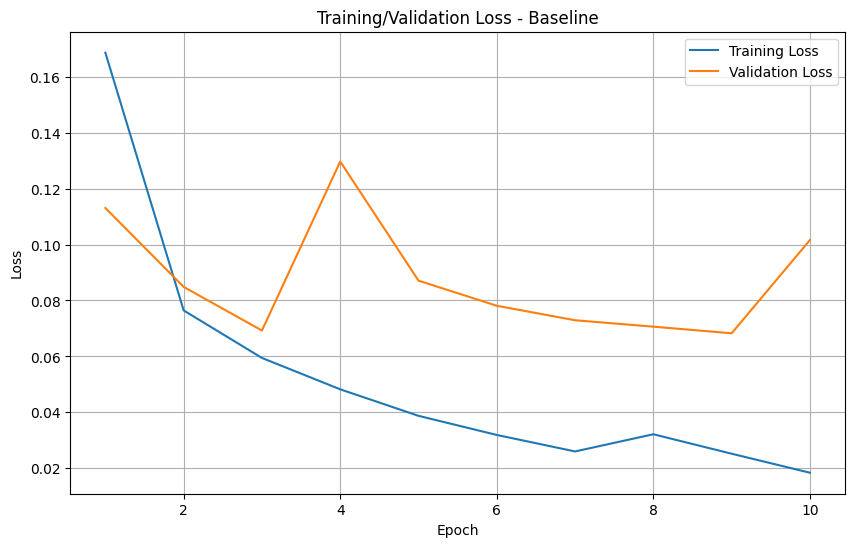

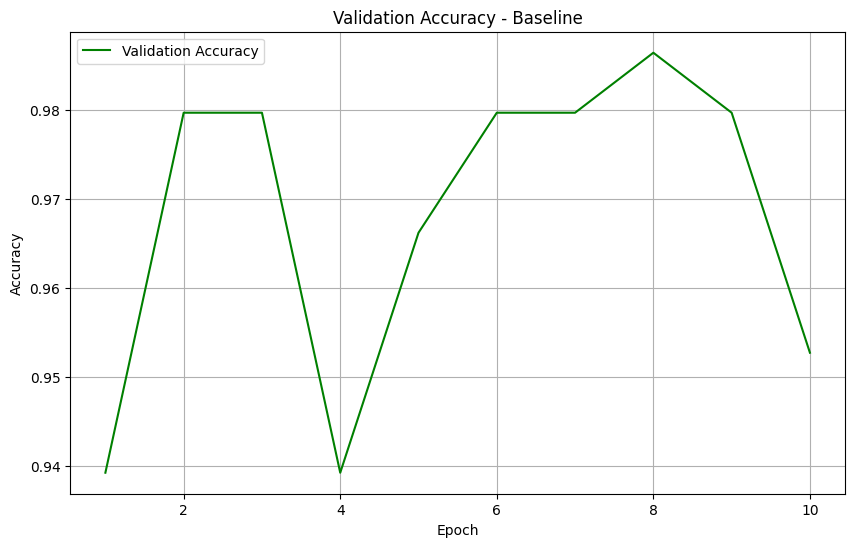

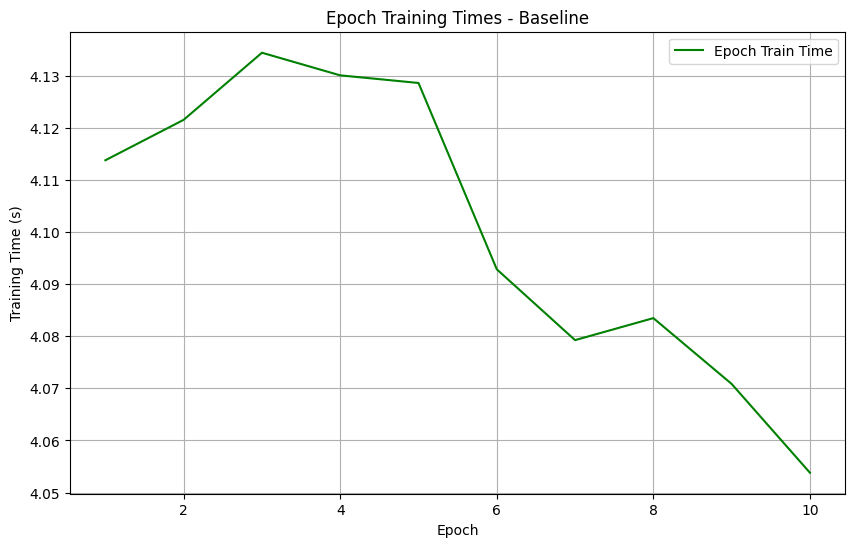

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = setup_lora_model(MODEL_NAME)

baseline_metrics = train_and_profile(model, tokenizer, "Baseline")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Torch.Compile ---


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s]


Epoch 1 | Training Time: 4.00s | Train Loss: 0.2053 | Val Loss: 0.1125 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.56it/s]


Epoch 2 | Training Time: 4.01s | Train Loss: 0.0897 | Val Loss: 0.0877 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.42it/s]


Epoch 3 | Training Time: 3.98s | Train Loss: 0.0612 | Val Loss: 0.1805 | Val Accuracy: 0.9257


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.19it/s]


Epoch 4 | Training Time: 4.00s | Train Loss: 0.0560 | Val Loss: 0.1111 | Val Accuracy: 0.9527


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.36it/s]


Epoch 5 | Training Time: 4.01s | Train Loss: 0.0447 | Val Loss: 0.1380 | Val Accuracy: 0.9257


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.32it/s]


Epoch 6 | Training Time: 4.02s | Train Loss: 0.0336 | Val Loss: 0.0827 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.26it/s]


Epoch 7 | Training Time: 4.04s | Train Loss: 0.0284 | Val Loss: 0.0828 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.04it/s]


Epoch 8 | Training Time: 4.05s | Train Loss: 0.0244 | Val Loss: 0.0889 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.26it/s]


Epoch 9 | Training Time: 4.06s | Train Loss: 0.0205 | Val Loss: 0.0866 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.26it/s]


Epoch 10 | Training Time: 4.05s | Train Loss: 0.0322 | Val Loss: 0.1049 | Val Accuracy: 0.9662


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.88it/s]


peak_gpu_memory,▁
test_accuracy,▁
test_loss,▁
throughput,▁
training_time,▁
peak_gpu_memory,1387.94287
test_accuracy,0.98649
test_loss,0.05565
throughput,276.13923
training_time,42.87692



--- Torch.Compile ---
Total Training Time: 42.88 seconds
Test Loss: 0.0556 | Test Accuracy: 0.9865
Throughput: 276.14 samples/sec
Peak GPU Memory Usage: 1387.94 MB


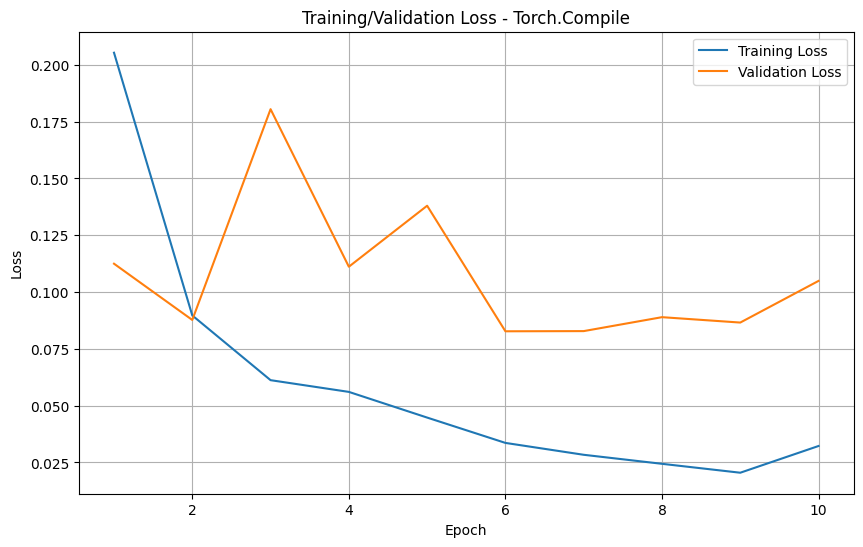

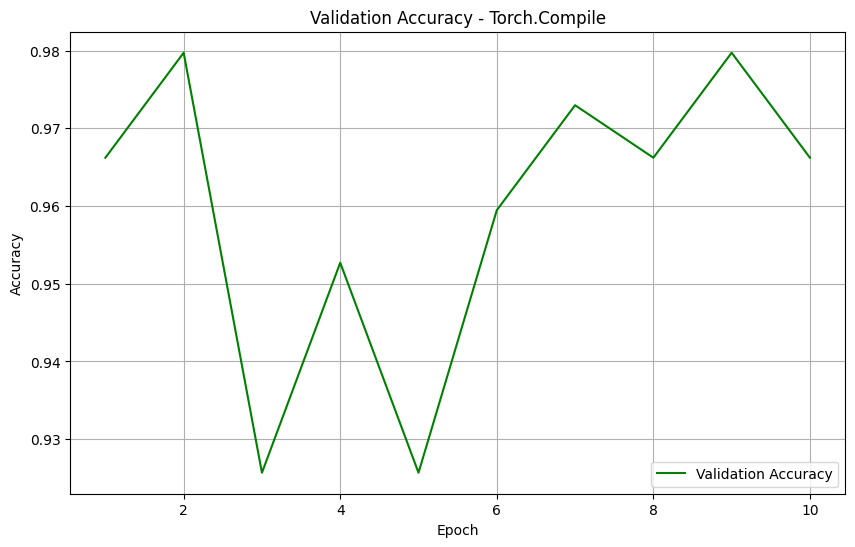

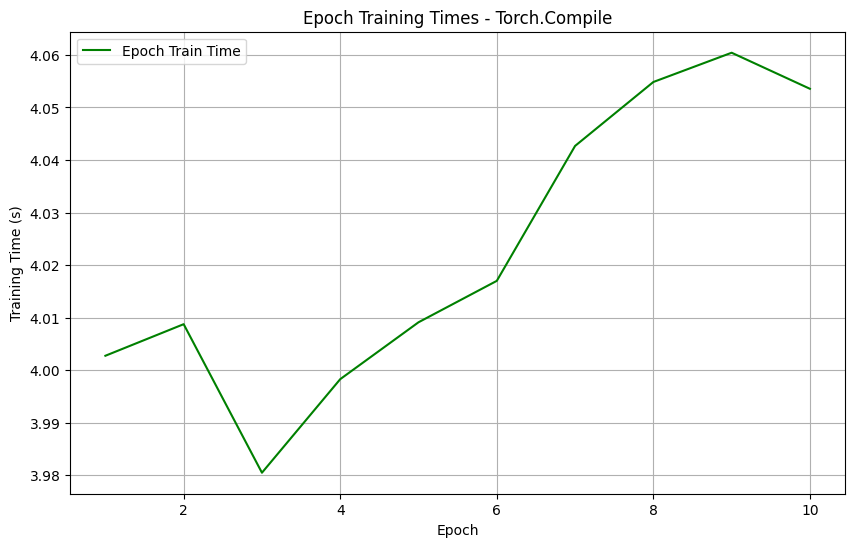

In [23]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = setup_lora_model(MODEL_NAME)

compiled_model = torch.compile(model)

torch_compile_metrics = train_and_profile(compiled_model, tokenizer, "Torch.Compile")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Torch.Compile Reduce-Overhead Mode ---


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 1 | Training Time: 6.17s | Train Loss: 0.2079 | Val Loss: 0.0985 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.40it/s]


Epoch 2 | Training Time: 4.01s | Train Loss: 0.0746 | Val Loss: 0.0855 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.34it/s]


Epoch 3 | Training Time: 4.04s | Train Loss: 0.0558 | Val Loss: 0.0719 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.16it/s]


Epoch 4 | Training Time: 4.07s | Train Loss: 0.0462 | Val Loss: 0.0808 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 18.90it/s]


Epoch 5 | Training Time: 4.08s | Train Loss: 0.0411 | Val Loss: 0.0852 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.24it/s]


Epoch 6 | Training Time: 4.07s | Train Loss: 0.0345 | Val Loss: 0.0887 | Val Accuracy: 0.9730


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.29it/s]


Epoch 7 | Training Time: 4.06s | Train Loss: 0.0380 | Val Loss: 0.0819 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.22it/s]


Epoch 8 | Training Time: 4.04s | Train Loss: 0.0280 | Val Loss: 0.1022 | Val Accuracy: 0.9595


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.17it/s]


Epoch 9 | Training Time: 4.05s | Train Loss: 0.0256 | Val Loss: 0.0669 | Val Accuracy: 0.9797


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.24it/s]


Epoch 10 | Training Time: 4.04s | Train Loss: 0.0198 | Val Loss: 0.0730 | Val Accuracy: 0.9865


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 19.60it/s]


peak_gpu_memory,▁
test_accuracy,▁
test_loss,▁
throughput,▁
training_time,▁
peak_gpu_memory,1560.68604
test_accuracy,0.98649
test_loss,0.06631
throughput,255.74149
training_time,46.29675



--- Torch.Compile Reduce-Overhead Mode ---
Total Training Time: 46.30 seconds
Test Loss: 0.0663 | Test Accuracy: 0.9865
Throughput: 255.74 samples/sec
Peak GPU Memory Usage: 1560.69 MB


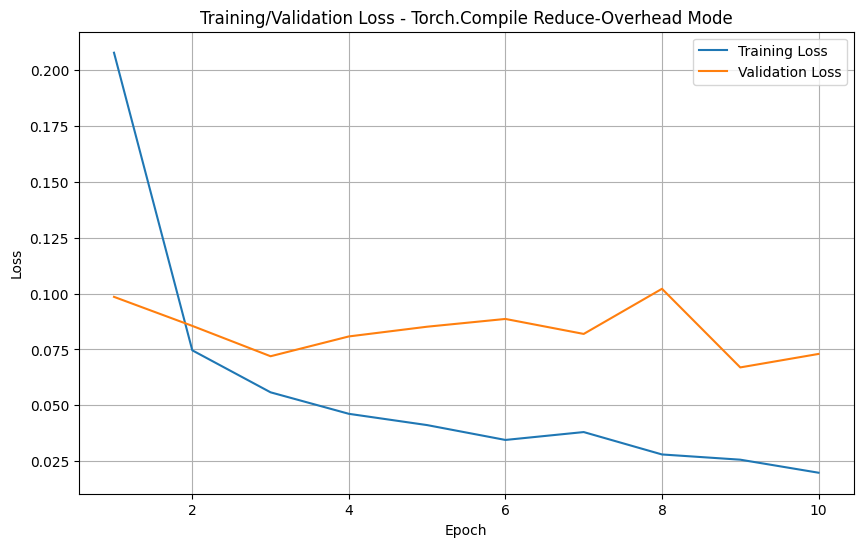

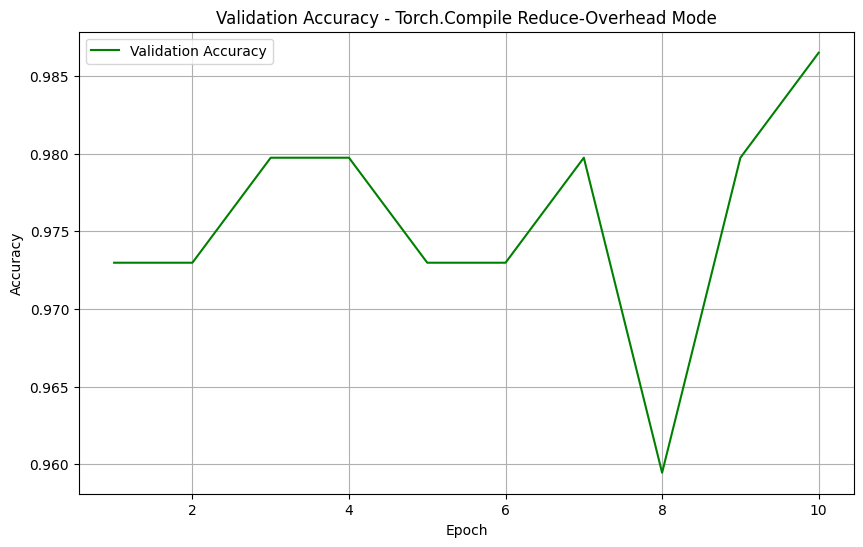

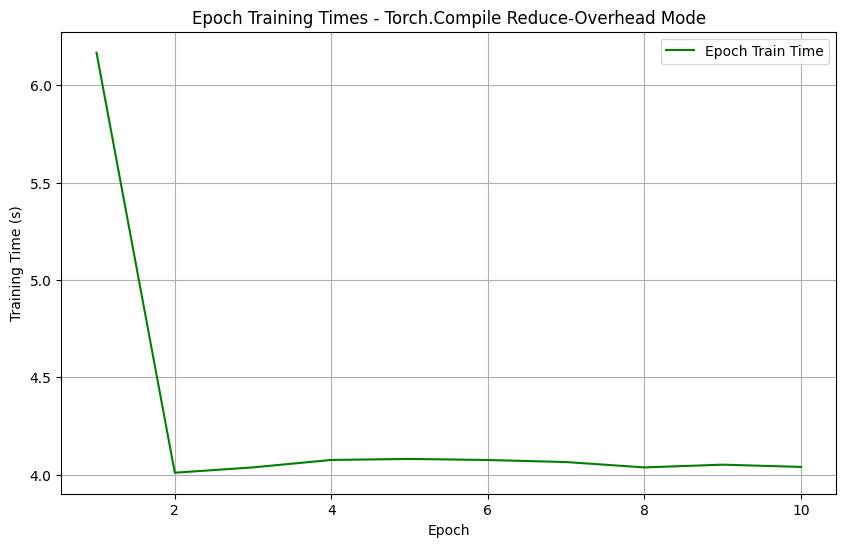

In [24]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = setup_lora_model(MODEL_NAME)

compiled_overhead_model = torch.compile(model, mode = "reduce-overhead")

compile_overhead_metrics = train_and_profile(compiled_overhead_model, tokenizer, "Torch.Compile Reduce-Overhead Mode")

In [25]:
def plot_metrics(baseline_metrics, torch_compile_metrics, compile_overhead_metrics):
    """
    Log a bar chart comparing training time, test accuracy, throughputs, and peak memory usages for all models.
    """

    models = ["Baseline", "Torch.Compile", "Torch.Compile\nReduce-Overhead\nMode"]

    training_times = [baseline_metrics["training_time"], torch_compile_metrics["training_time"], compile_overhead_metrics["training_time"]]
    test_accuracies = [baseline_metrics["test_accuracy"], torch_compile_metrics["test_accuracy"], compile_overhead_metrics["test_accuracy"]]
    throughputs = [baseline_metrics["throughput"], torch_compile_metrics["throughput"], compile_overhead_metrics["throughput"]]
    peak_memory_usages = [baseline_metrics["peak_memory_usage"], torch_compile_metrics["peak_memory_usage"], compile_overhead_metrics["peak_memory_usage"]]


    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()
    axs[0].bar(models, training_times, color=["blue", "green", "red"])
    axs[0].set_title("Training Times")
    axs[0].set_ylabel("Seconds")
    #axs[0].set_xticklabels(models, rotation=45)

    axs[1].bar(models, test_accuracies, color=["blue", "green", "red"])
    axs[1].set_title("Test Accuracies")
    axs[1].set_ylabel("Accuracy")

    axs[2].bar(models, throughputs, color=["blue", "green", "red"])
    axs[2].set_title("Throughput")
    axs[2].set_ylabel("Samples/sec")

    axs[3].bar(models, peak_memory_usages, color=["blue", "green", "red"])
    axs[3].set_title("Peak GPU Memory Usage")
    axs[3].set_ylabel("MB")


    run_g = wandb.init(project="chemberta", entity="hpml-proj-deepchem", name=f"Torch_compile_metrics")
    wandb.log({f"Torch_compile_metrics": wandb.Image(fig)})
    wandb.finish()

    plt.tight_layout()



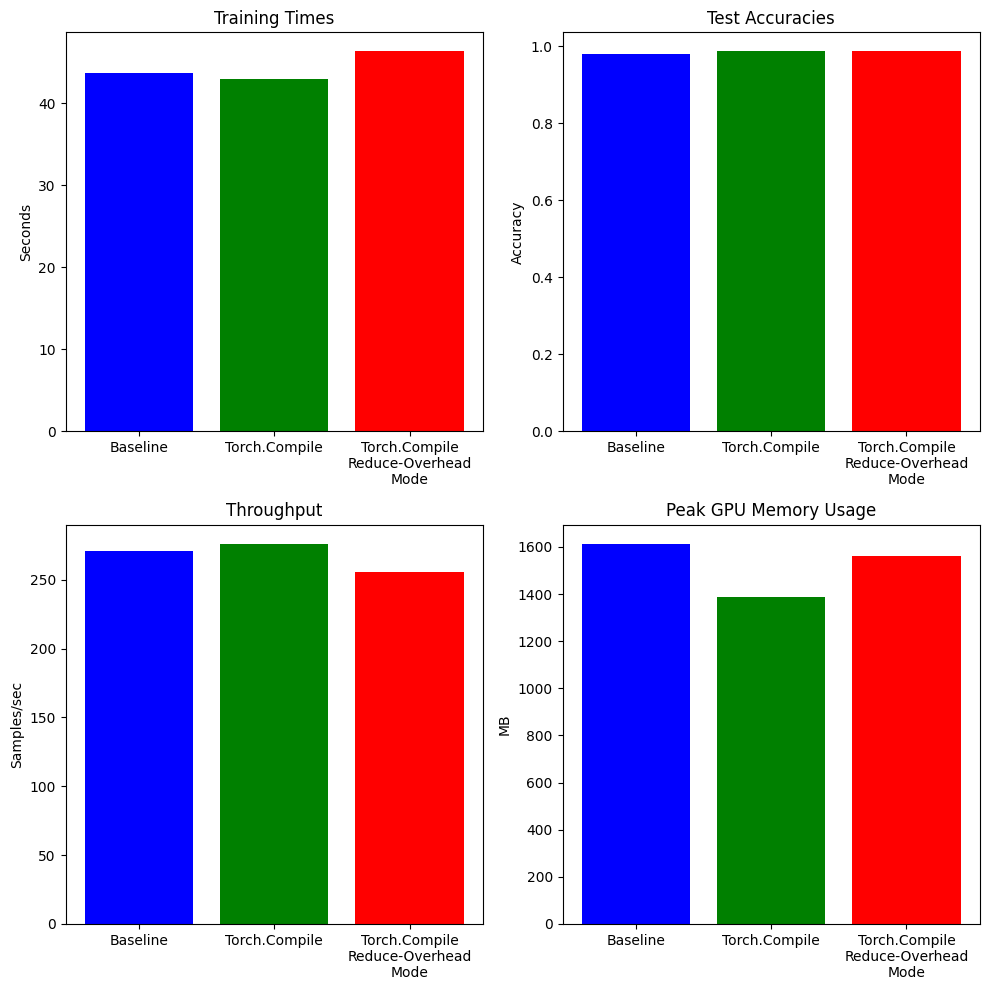

In [26]:
plot_metrics(baseline_metrics, torch_compile_metrics, compile_overhead_metrics)

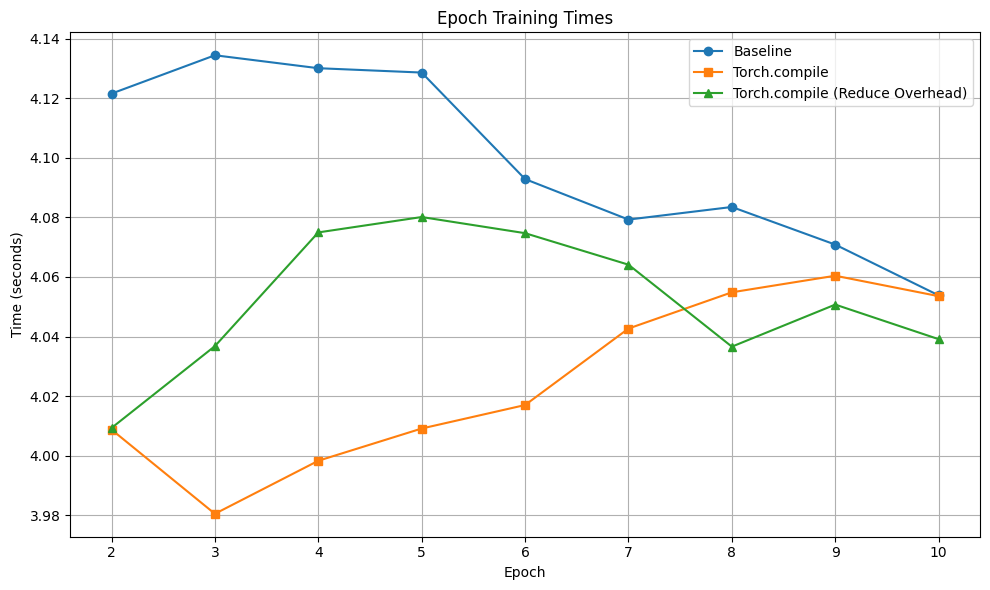

In [27]:
def plot_epoch_times(baseline_metrics, torch_compile_metrics, compile_overhead_metrics):
    baseline_times = baseline_metrics["epoch_times"]
    torch_compile_times = torch_compile_metrics["epoch_times"]
    compile_overhead_times = compile_overhead_metrics["epoch_times"]

    # Only show epochs 2 to 10
    epochs = list(range(2, 11))
    baseline_times = baseline_times[1:10]
    torch_compile_times = torch_compile_times[1:10]
    compile_overhead_times = compile_overhead_times[1:10]

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, baseline_times, marker='o', label='Baseline')
    plt.plot(epochs, torch_compile_times, marker='s', label='Torch.compile')
    plt.plot(epochs, compile_overhead_times, marker='^', label='Torch.compile (Reduce Overhead)')
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    plt.title("Epoch Training Times")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    run_2 = wandb.init(project="chemberta", entity="hpml-proj-deepchem", name=f"Torch_compile_training_times")
    wandb.log({f"Torch_compile_training_times": wandb.Image(plt)})

    plt.show()

    wandb.finish()


plot_epoch_times(baseline_metrics, torch_compile_metrics, compile_overhead_metrics)

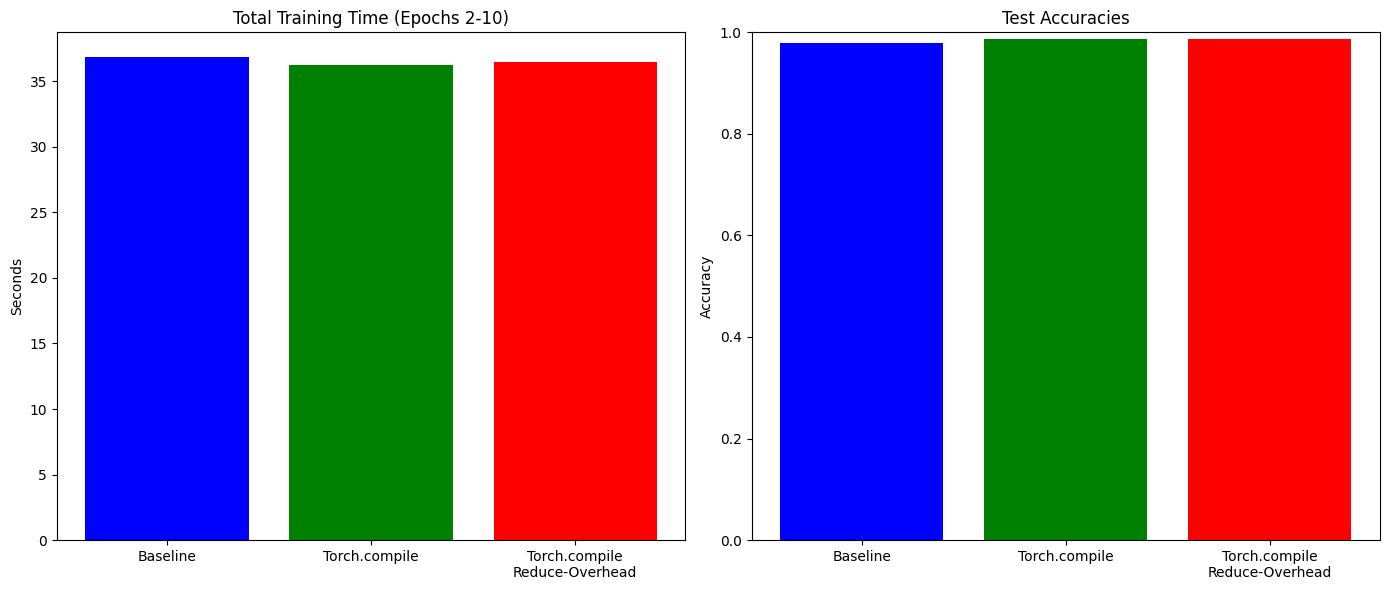

In [28]:
def plot_epoch_times_and_accuracy(baseline_metrics, torch_compile_metrics, compile_overhead_metrics):
    # Extract and sum epoch times for epochs 2-10
    baseline_times = baseline_metrics["epoch_times"][1:10]
    torch_compile_times = torch_compile_metrics["epoch_times"][1:10]
    compile_overhead_times = compile_overhead_metrics["epoch_times"][1:10]

    total_baseline_time = sum(baseline_times)
    total_torch_compile_time = sum(torch_compile_times)
    total_compile_overhead_time = sum(compile_overhead_times)

    # Extract test accuracies
    baseline_acc = baseline_metrics["test_accuracy"]
    torch_compile_acc = torch_compile_metrics["test_accuracy"]
    compile_overhead_acc = compile_overhead_metrics["test_accuracy"]


    models = ["Baseline", "Torch.compile", "Torch.compile\nReduce-Overhead"]

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Training time subplot
    axs[0].bar(models,
               [total_baseline_time, total_torch_compile_time, total_compile_overhead_time],
               color=["blue", "green", "red"])
    axs[0].set_title("Total Training Time (Epochs 2-10)")
    axs[0].set_ylabel("Seconds")


    # Test accuracy subplot
    axs[1].bar(models,
               [baseline_acc, torch_compile_acc, compile_overhead_acc],
               color=["blue", "green", "red"])
    axs[1].set_title("Test Accuracies")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim(0, 1)  # Set y-axis from 0 to 1 for accuracy

    plt.tight_layout()

    run = wandb.init(project="chemberta", entity="hpml-proj-deepchem",
                    name="Training_Time_and_Accuracy_Comparison_compile")
    wandb.log({"training_time_and_accuracy_compile": wandb.Image(fig)})
    wandb.finish()


    plt.show()

plot_epoch_times_and_accuracy(baseline_metrics, torch_compile_metrics, compile_overhead_metrics)
